In [1]:
import sklearn
from sklearn.datasets import make_moons


In [2]:
n_samples = 1000
X, y = make_moons(n_samples=n_samples,
                  noise=0.1,
                  random_state=42)

In [3]:
X[:5], y[:5]

(array([[-0.05146968,  0.44419863],
        [ 1.03201691, -0.41974116],
        [ 0.86789186, -0.25482711],
        [ 0.288851  , -0.44866862],
        [-0.83343911,  0.53505665]]),
 array([1, 1, 1, 1, 0]))

In [4]:
import pandas as pd
moons = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
moons.head(10)

,X1,X2,label
0,-0.051470,0.444199,1
1,1.032017,-0.419741,1
2,0.867892,-0.254827,1
3,0.288851,-0.448669,1
4,-0.833439,0.535057,0
5,0.613706,-0.242369,1
6,0.286495,-0.201277,1
7,-0.056104,0.477079,1
8,1.604217,-0.303541,1
9,0.709641,0.858867,0


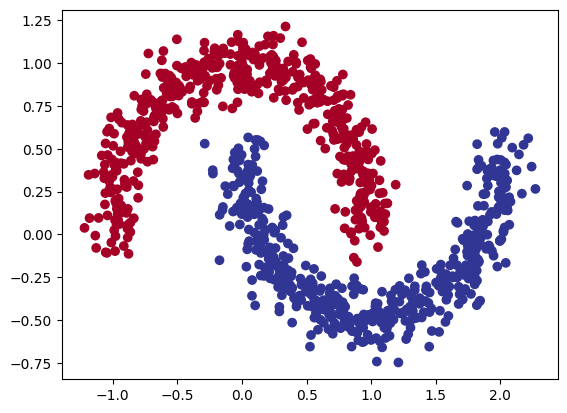

In [5]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [6]:
import torch

In [7]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [9]:
X_train[:5], y_train[:5]

(tensor([[ 2.0433,  0.2758],
         [-1.0620,  0.4074],
         [-0.1452,  1.0842],
         [-0.0897,  0.9887],
         [ 0.3838, -0.2208]]),
 tensor([1., 0., 0., 0., 1.]))

In [10]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [11]:
class MoonsModelV0(nn.Module):
  def __init__(self, inputs, outputs, hidden):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=inputs, out_features=hidden)
    self.layer_2 = nn.Linear(in_features=hidden, out_features=hidden)
    self.layer_3 = nn.Linear(in_features=hidden, out_features=outputs)
    self.relu = nn.Tanh()

  def forward(self, x):
    x = self.layer_1(x)
    x = self.relu(x)
    x = self.layer_2(x)
    x = self.relu(x)
    x = self.layer_3(x)
    return x

moons_model_1 = MoonsModelV0(inputs=2, outputs=1, hidden=64)
moons_model_1.to(device)


MoonsModelV0(
  (layer_1): Linear(in_features=2, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_3): Linear(in_features=64, out_features=1, bias=True)
  (relu): Tanh()
)

In [12]:
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [13]:
moons_model_1.eval()
y_logits = moons_model_1.forward(X_train)
y_pred_probs = torch.sigmoid(y_logits)
y_preds = torch.round(y_pred_probs)
# y_logits[:5], y_pred_probs[:5], y_preds[:5], y_train[:5]

In [14]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [15]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=moons_model_1.parameters(), lr=0.1)

In [16]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [17]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1200

for epoch in range(epochs):
  moons_model_1.train()

  y_logits = moons_model_1.forward(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
  
  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  moons_model_1.eval()
  with torch.inference_mode():
    test_logits = moons_model_1.forward(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)
    
  if epoch % 50 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.70363, Acc: 50.00% | Test loss: 0.81782, Test acc: 76.50%
Epoch: 50 | Loss: 0.00084, Acc: 100.00% | Test loss: 0.00043, Test acc: 100.00%
Epoch: 100 | Loss: 0.00025, Acc: 100.00% | Test loss: 0.00014, Test acc: 100.00%
Epoch: 150 | Loss: 0.00018, Acc: 100.00% | Test loss: 0.00011, Test acc: 100.00%
Epoch: 200 | Loss: 0.00013, Acc: 100.00% | Test loss: 0.00008, Test acc: 100.00%
Epoch: 250 | Loss: 0.00011, Acc: 100.00% | Test loss: 0.00007, Test acc: 100.00%
Epoch: 300 | Loss: 0.00009, Acc: 100.00% | Test loss: 0.00006, Test acc: 100.00%
Epoch: 350 | Loss: 0.00007, Acc: 100.00% | Test loss: 0.00005, Test acc: 100.00%
Epoch: 400 | Loss: 0.00006, Acc: 100.00% | Test loss: 0.00004, Test acc: 100.00%
Epoch: 450 | Loss: 0.00005, Acc: 100.00% | Test loss: 0.00003, Test acc: 100.00%
Epoch: 500 | Loss: 0.00004, Acc: 100.00% | Test loss: 0.00003, Test acc: 100.00%
Epoch: 550 | Loss: 0.00004, Acc: 100.00% | Test loss: 0.00003, Test acc: 100.00%
Epoch: 600 | Loss: 0.00003, Acc: 

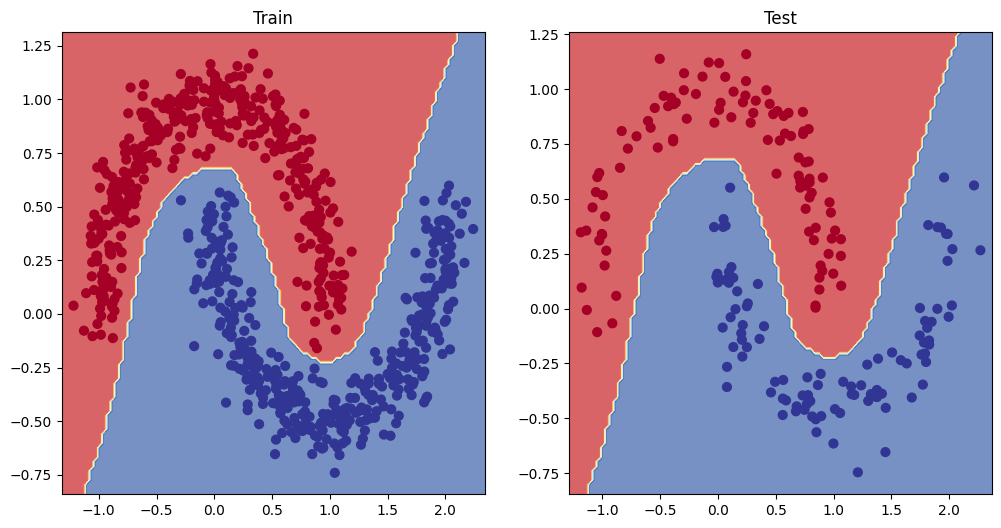

In [18]:
from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(moons_model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(moons_model_1, X_test, y_test)

In [19]:
def tanh_func(x):
  return (torch.e**x-torch.e**-x)/(torch.e**x+torch.e**-x)
torch.tanh(torch.tensor(1)), tanh_func(1)

(tensor(0.7616), 0.7615941559557649)

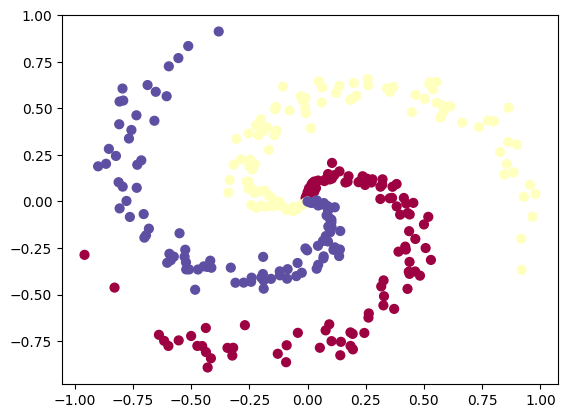

In [20]:
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [21]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.long)

In [22]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [24]:
class SpiralSplitterV0(nn.Module):
  def __init__(self, input, output, hidden):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=input, out_features=hidden)
    self.layer_2 = nn.Linear(in_features=hidden, out_features=hidden)
    self.layer_3 = nn.Linear(in_features=hidden, out_features=output)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.layer_1(x)
    x = self.relu(x)
    x = self.layer_2(x)
    x = self.relu(x)
    x = self.layer_3(x)
    return x
  
spiral_model = SpiralSplitterV0(input=2, output=3, hidden=32)
spiral_model.to(device)

SpiralSplitterV0(
  (layer_1): Linear(in_features=2, out_features=32, bias=True)
  (layer_2): Linear(in_features=32, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=3, bias=True)
  (relu): ReLU()
)

In [25]:
spiral_model.eval()
y_logits = spiral_model(X_train)
y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1).type(torch.float)
y_logits[:5],y_pred[:5], y_train[:5]

(tensor([[-0.1235,  0.0770,  0.0002],
         [-0.1368,  0.0791, -0.0043],
         [-0.1263,  0.0710,  0.0173],
         [-0.1344,  0.1018,  0.0347],
         [-0.1165,  0.1026,  0.0528]], device='cuda:0',
        grad_fn=<SliceBackward0>),
 tensor([1., 1., 1., 1., 1.], device='cuda:0'),
 tensor([2, 0, 0, 1, 1], device='cuda:0'))

In [26]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=spiral_model.parameters(),lr=0.1, momentum=0.9)

In [27]:
epochs = 1000

for epoch in range(epochs):
  spiral_model.train()

  y_logits = spiral_model(X_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1).type(torch.float)

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  spiral_model.eval()
  with torch.inference_mode():
    test_logits = spiral_model(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1).type(torch.float)

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  if epoch % 50 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
     
      

Epoch: 0 | Loss: 1.10452, Acc: 35.00% | Test loss: 1.11374, Test acc: 26.67%
Epoch: 50 | Loss: 0.60185, Acc: 65.83% | Test loss: 0.64548, Test acc: 55.00%
Epoch: 100 | Loss: 0.32466, Acc: 87.92% | Test loss: 0.31517, Test acc: 88.33%
Epoch: 150 | Loss: 0.14010, Acc: 95.00% | Test loss: 0.11724, Test acc: 93.33%
Epoch: 200 | Loss: 0.07926, Acc: 97.92% | Test loss: 0.05508, Test acc: 100.00%
Epoch: 250 | Loss: 0.05752, Acc: 98.75% | Test loss: 0.03239, Test acc: 100.00%
Epoch: 300 | Loss: 0.04778, Acc: 98.75% | Test loss: 0.02280, Test acc: 100.00%
Epoch: 350 | Loss: 0.04204, Acc: 99.17% | Test loss: 0.01705, Test acc: 100.00%
Epoch: 400 | Loss: 0.03807, Acc: 99.17% | Test loss: 0.01333, Test acc: 100.00%
Epoch: 450 | Loss: 0.03515, Acc: 99.17% | Test loss: 0.01086, Test acc: 100.00%
Epoch: 500 | Loss: 0.03278, Acc: 99.17% | Test loss: 0.00894, Test acc: 100.00%
Epoch: 550 | Loss: 0.03083, Acc: 99.17% | Test loss: 0.00741, Test acc: 100.00%
Epoch: 600 | Loss: 0.02919, Acc: 99.17% | Test 

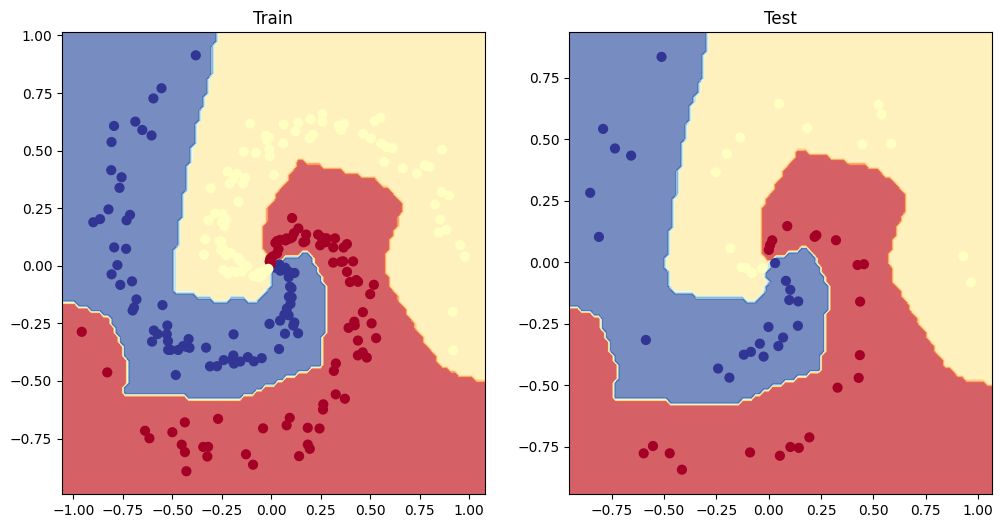

In [28]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(spiral_model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(spiral_model, X_test, y_test)